In [1]:
%matplotlib inline

/home/main/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
FFMPEG_BIN = 'ffmpeg'
frame_width  = 48
frame_height = 54
frame_depth  =  3 # (number of colors)
frame_dim = (frame_height, frame_width, frame_depth)  # height x width x num_colors(depth)

In [4]:
import subprocess as sp
command = [ FFMPEG_BIN,
            '-i', 'fareeds_take.2015.09.21.speech.full_res.crop.048x054.mov',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
video_pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

In [5]:
# Import the movie file into a python array of images.

from IPython import display

frames = []
while video_pipe:
    # read 1 frame bytes
    raw_image = video_pipe.stdout.read(frame_dim[0]*frame_dim[1]*frame_dim[2])
    if not raw_image:
        break
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape(frame_dim)
    frames.append(image)
    # throw away the data in the pipe's buffer.
    video_pipe.stdout.flush()
    
len(frames)

4739

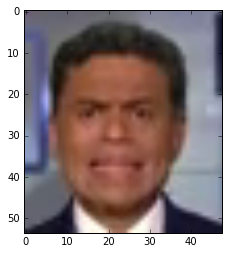

In [6]:
def play_frames_clip(frames):
    ''' frames -- a list/array of np.array images. Plays all frames in the notebook as a clip.'''
    for frame in frames:
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)

play_frames_clip(frames[10:20])

In [7]:
# True means it came from the GAN (it was generated).
false_frames  = frames
true_frames = [np.random.random(frames[0].shape) * 255 for _ in range(len(frames))]

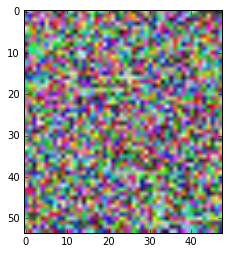

In [8]:
play_frames_clip(true_frames[10:20])

In [9]:
labelled_inputs = [(x.flatten(),1) for x in true_frames] + [(x.flatten(),0) for x in false_frames]
np.random.shuffle(labelled_inputs)

In [96]:
num_total_inputs = len(labelled_inputs)

Xtrain = labelled_inputs[0:num_total_inputs*6/10]
Xcv    = labelled_inputs[num_total_inputs*6/10:num_total_inputs*8/10]
Xtest  = labelled_inputs[num_total_inputs*8/10:]

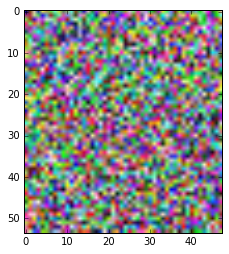

In [11]:
play_frames_clip([x[0].reshape(frame_dim) for x in Xtrain[10:20]])

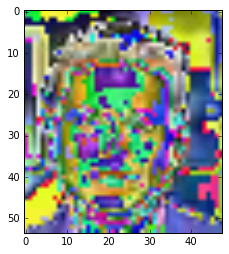

In [134]:
def normalize(x):
    mu = np.mean(x)
    sigma = np.std(x)
    x_norm = (x - mu) / sigma  # All element-wise
    return x_norm
play_frames_clip([normalize(x) for x in false_frames[:10]])

### Build the Discriminator

In [135]:
import tensorflow as tf

In [136]:
flattened_image_len = frames[0].flatten().shape[0]
dim_X  = flattened_image_len
dim_h1 = 5
dim_h2 = 5
dim_h3 = 5
dim_y  = 1

In [214]:
print flattened_image_len
W1 = tf.Variable(tf.random_uniform([dim_X,dim_h1], maxval=0.01, minval=-0.01), name='W1') 
b1 = tf.Variable(tf.zeros([dim_h2]), name='b1')
W2 = tf.Variable(tf.random_uniform([dim_h1,dim_h2], maxval=0.01, minval=-0.01), name='W2') 
b2 = tf.Variable(tf.zeros([dim_h3]), name='b2')
W3 = tf.Variable(tf.random_uniform([dim_h2,dim_h3], maxval=0.01, minval=-0.01), name='W3') 
b3 = tf.Variable(tf.zeros([dim_y]), name='b3')
Wy = tf.Variable(tf.random_uniform([dim_h3,dim_y], maxval=0.01, minval=-0.01), name='W3') 
by = tf.Variable(tf.zeros([1]), name='by')

7776


In [215]:
X = tf.placeholder(tf.float32, [None, flattened_image_len], name='images') # Images (in a batch)
a1 = X
a2 = tf.nn.sigmoid(tf.matmul(a1, W1) + b1)
a3 = tf.nn.sigmoid(tf.matmul(W1, W2) + b2)
a4 = tf.nn.sigmoid(tf.matmul(W2, W3) + b3)
ay = tf.nn.sigmoid(tf.matmul(W3, Wy) + by)
y = ay        # Confidence the image is generated by GAN.

In [216]:
truth = tf.placeholder(tf.float32, [None], name='truth')

#cost = tf.reduce_mean(tf.reduce_sum(-truth*tf.log(y) - (1-truth)*tf.log(1-y)));  # multiplication is element-wise
cost_unreg = tf.reduce_mean(tf.reduce_sum(-truth*tf.log(y) - (1-truth)*tf.log(1-y)));  # multiplication is element-wise

m = tf.to_float(tf.shape(truth))  # Number of input pairs.
reg_lambda = tf.placeholder(tf.float32, 1, name='lambda')

theta_sums = tf.reduce_sum(W1**2) + tf.reduce_sum(W2**2) + tf.reduce_sum(W3**2) + tf.reduce_sum(Wy**2)
cost_reg   = cost_unreg + (reg_lambda / (2*m)) * theta_sums

In [254]:
learning_rate = 0.001
sess = tf.Session()


In [255]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_reg)

In [291]:
def trainLogisticRegression(training_examples, regularization_lambda):
    global sess
    init = tf.initialize_all_variables()
    sess.run(init)
    losses = []
    iteration = 0
    for i in range(100):
        normalized_inputs = np.array([normalize(x[0]) for x in training_examples])
        labels = np.array([x[1] for x in training_examples])

        feed_dict={X:normalized_inputs, truth:labels, reg_lambda:[regularization_lambda]}
        _,[loss],y_out = sess.run((train_step, cost_reg, y), feed_dict=feed_dict)
        losses.append(loss)
        iteration += 1
        loss,y_out.flatten()
    return losses

losses = trainLogisticRegression(Xtrain[:20], 30)

In [292]:
print losses[:5]
print losses[-5:]
print np.max(losses)
print np.min(losses)

[70.285355, 69.665207, 69.075523, 68.514824, 67.981644]
[57.179741, 57.169113, 57.158821, 57.148861, 57.139225]
70.2854
57.1392


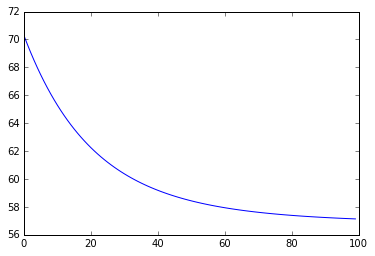

In [293]:
plt.plot(losses[:100])

## Let's look at the Learning Curves to diagnose what's wrong!

In [303]:
def logisticRegressionCostFunction(input_pairs, regularization_lambda):
    normalized_inputs = np.array([normalize(x[0]) for x in input_pairs])
    labels = np.array([x[1] for x in input_pairs])

    feed_dict={X:normalized_inputs, truth:labels, reg_lambda:[regularization_lambda]}
    [loss] = sess.run((cost_reg), feed_dict=feed_dict)
    return loss
logisticRegressionCostFunction(Xtrain[:10], 2)

30.741949

In [304]:
# Plot how well it can learn 

Training with subset of size 1000 -- error_train: 3462.47265625, error_val: 6582.59130859


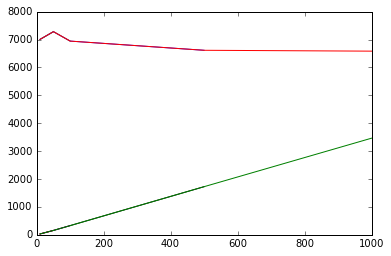

In [ ]:
regularization_lambda = 100
error_train = []
error_val = []
subset_sizes = [10, 50, 100, 500, 1000]
for idx,subset_size in enumerate(subset_sizes):
    train_subset = Xtrain[:subset_size]
    _ = trainLogisticRegression(train_subset, regularization_lambda)
    
    # Now calculate the loss for the theta trained with this training subset.
    #  Note, don't regularize when calculating actual loss.
    error_train.append(logisticRegressionCostFunction(train_subset, 0))
    error_val.append(logisticRegressionCostFunction(Xcv, 0))
    print "Training with subset of size {0} -- error_train: {1}, error_val: {2}".format(subset_size, error_train[-1], error_val[-1])

    plt.plot(subset_sizes[:idx+1], error_train, subset_sizes[:idx+1], error_val)
    display.display(plt.gcf())
    display.clear_output(wait=True)


SO! Because the gap between the two curves above is high, we are sufferring from High Variance, which makes sense since the model as I've defined it is so complicated!

I should either try to simplify the algorithm or get way more data!

In [ ]:
# Down-scale the image.
import scipy
import scipy.misc
new_shape = np.array(image.shape) / 3
new_shape[2] = 3
small_image = scipy.misc.imresize(image, new_shape)

In [ ]:
plt.imshow(small_image)
small_image.shape